### Visualizing Behavior

#### J. Carpenter 2020

### Load data:

In [25]:
# import libraries
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [26]:
# Load dataset
fileLoc = "D:\\Data\\Dataset\\24116.mat"
matfile = sio.loadmat(fileLoc) # load .mat file

### Define functions:

In [27]:
def smooth(data, sigma, **kwargs):
    
    # credit: Simon Ball, Moser Group (2020)
    
    d = data.ndim
    
    if  d == 2:
        kernel = Gaussian2DKernel(x_stddev = sigma)
    elif d == 1:
        kernel = Gaussian1DKernel(stddev = sigma)
    else:
        raise NotImplementedError("This function currently supports smoothing"\
                f" 1D, 2D data. You have provided {d} dimensional data")

    mask_fill = 0 # Replacement value for masked values when smoothing. Use np.nan to interpolate through masked values instead of use fixed value

    mask_fill = kwargs.get('mask_fill', mask_fill)
    circular = kwargs.get("circular", False)
    if not isinstance(circular, bool):
        raise ValueError("You must provide a boolean (True/False) value for"\
                         f" keyword 'circular'. You provided {circular}, which"\
                         f" is type {type(circular)}")

    working_data = data.copy()
    if type(data) == np.ma.MaskedArray:
        working_data[data.mask] = mask_fill

    width = int(4*sigma)

    if circular:
        smoothed_data = convolve(working_data, kernel, boundary = "wrap")
        # Don't bother with padding. Use the values from the other end of the 
        # array, i.e. imagine the array wrapped around a cylinder
    elif not circular:
        working_data = np.pad(working_data, pad_width = width, mode = 'symmetric')
        # pad the outer boundary to depth "width
        # The padding values are based on reflecting at the border
        # mode='symmetrical' results in
        # [0, 1, 2, 3, 4] -> [1,0  ,0,1,2,3,4,  4,3]
        # mode='reflect' results in
        # [0, 1, 2, 3, 4] -> [2,1  ,0,1,2,3,4,  3,2]
        # i.e. changing whether the reflection axis is outside the original data
        # or overlaid on the outermost row
    
        smoothed_data = convolve(working_data, kernel, boundary = 'extend')
        # Because of the padding, the boundary mode isn't really relevant
        # By choosing a large width, the edge effects arising from this additional
        # padding (boundary='extend') is minimised
    
        if d == 2:
            smoothed_data = smoothed_data[width:-width, width:-width]
        elif d == 1:
            smoothed_data = smoothed_data[width:-width]
        else: # This condition should never happen, due to checking above
            raise NotImplementedError("This function currently supports smoothing"\
                    f" 1D, 2D data. You have provided {d} dimensional data")
        # We have to get rid of the padding that we previously added, and the only
        # way to do that is slicing, which is NOT dimensional-agnostic
        # There may be a more elegant solution than if/else, but this will do now

    if type(data) == np.ma.MaskedArray:
        smoothed_data = np.ma.masked_where(data.mask, smoothed_data)
        smoothed_data.data[data.mask] = data.data[data.mask]

    return smoothed_data

In [28]:
def makeDF(matfile, sessNum, unitNum):
    # make dataframe to pass through plotly for one session
    # this may be too computationally heavy
    
    pos = matfile["pos"][0] # time & LEDs
    time = pos[sessNum][:,0]
    led1A = pos[sessNum][:,1]; led1B = pos[sessNum][:,2];
    led2A = pos[sessNum][:,3]; led2B = pos[sessNum][:,4];
      
    SpikeTrain = matfile["SpikeTrain"][0][sessNum][0]    
    if np.size(SpikeTrain) > 0: 
        SpikeTrainUnit = SpikeTrain[unitNum][0]
        d = {'time': time, 'led1A': led1A , 'led1B': led1B, 'led2A': led2A, 'led2B': led2B, 'spikes:': SpikeTrainUnit}
    else:
        d = {'time': time, 'led1A': led1A , 'led1B': led1B, 'led2A': led2A, 'led2B': led2B}
    df = pd.DataFrame(data=d)
    
    return df

In [29]:
# def makeAnimation(df):
#     px.scatter(df, x="led1A", y="led1B", animation_frame="time")

In [30]:
def getUnitData(matfile, sessNum, unitNum):
    
    """
    The following data will be loaded (via scipy.io):
    
        'SpikeTrain':    Sx1 array, where S is the number of sessions for the animal. 
                         Each session (S) contains a Nx1 vector, where N is the number of 
                         neurons (units) recorded in a given session.
                      
        'pos':           Sx1 array containing information about time and the positions of 2 LEDs.
        
        'UniqueID':      Sx1 array, where each array contains an Nx1 vector. Each element is a 
                         string value, containing the unique cell ID for the given unit.
        
        'trialType':    Sx1 array, containing a string value of session type (FM or OF, for
                        'Foster Maze' or 'Open Field', respectively. 'TS' might also be present,
                         which stands for 'Training Session'.
                         
    Outputs:
    
        'time':         tx1 array, where t is the number of timestamps for the session.
    """
    
        
    # pull out relevant arrays
    SpikeTrain = matfile["SpikeTrain"][0]
    pos = matfile["pos"][0] # time & LEDs
    UniqueID = matfile["UniqueID"][0]
    trialType = matfile["trialType"][0]
    
    
    # trial type, spike train, unique ID #
    spikesNow = SpikeTrain[sessNum][0][unitNum][0]
    trialNow = str(trialType[sessNum][0])
    idNow = str(UniqueID[sessNum][0][unitNum][0][0])
    info = [idNow, sessNum, trialNow]
    
    # get window maximums and minumums
    minX = float(matfile["sessInfo"][0][sessNum][0]["window_min_x"][0][0][0][0])
    maxX = float(matfile["sessInfo"][0][sessNum][0]["window_max_x"][0][0][0][0])
    minY = float(matfile["sessInfo"][0][sessNum][0]["window_min_y"][0][0][0][0])
    maxY = float(matfile["sessInfo"][0][sessNum][0]["window_max_y"][0][0][0][0])
    window = np.array([minX, maxX, minY, maxY])
    
    return window, spikesNow, info

In [31]:
def getTimePt(matfile, sessNum, timePoint):
    
    # parse position vector
    pos = matfile["pos"][0]
    time = pos[sessNum][:,0][timePoint];
    led1A = pos[sessNum][:,1][timePoint]; led1B = pos[sessNum][:,2][timePoint];
    led2A = pos[sessNum][:,3][timePoint]; led2B = pos[sessNum][:,4][timePoint];
    led = np.array([time, led1A, led1B, led2A, led2B])
    
    return time, led

In [32]:
def plotBehavior(led, window, info):
    """
    plots behavior for a single timepoint.
    """
    
    # parse window vector
    minX = window[0]; maxX = window[1]; minY = window[2]; maxY = window[3]
    
    # parse led vector
    time = led[0]
    L1A = led[1]; L1B = led[2]; L2A = led[3]+10; L2B = led[4]+10 # offset second LED
    
    # make title
    plot_title = 'uid:' + str(info[0]) + ' / sess:' + str(info[1]) + ' / type:' + str(info[2]) + '/ t(ms):' + str(time)
    
    # plot LEDs at timepoint
    fig, ax = plt.subplots(figsize = (6,6))
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left()  
    
    ax.hlines(y = minY, xmin = minX, xmax = maxX, linestyles='dashed') #minY
    ax.hlines(y = maxY, xmin = minX, xmax = maxX, linestyles='dashed') # maxY
    ax.vlines(x = minX, ymin = minY, ymax = maxY, linestyles='dashed') # minX
    ax.vlines(x = maxX, ymin = minY, ymax = maxY, linestyles='dashed') # maxX
    
    ax.scatter(L1A, L1B, s=25, c='red')
    ax.scatter(L2A, L2B, s=25, c='blue')
    
    font = {'fontname':'Helvetica'}
    ax.set_xlabel("x", **font, fontsize=14);
    ax.set_ylabel("y", **font, fontsize=14);
    ax.set_title(plot_title, **font,fontsize=16);
    ax.axis('square')
    
    # save figure
    pngName = 'D:\\behaviorVideos\\24116\\' + str(time) + '.png'
    fig.savefig(pngName)
    
    # close figure
    plt.close()
    
    return

In [33]:
def makeSpikePlot(matfile, sessNum, unitNum, timePoint):
    
    SpikeTrain = matfile["SpikeTrain"][0]
    spikesNow = SpikeTrain[sessNum][0][unitNum][0]
    pos = matfile["pos"][0]
    time = pos[sessNum][:,0][timePoint];

In [8]:
def genImage(matfile, sessNum, unitNum):
    # generate & save .png
    
    SpikeTrain = matfile["SpikeTrain"][0][sessNum][0]
    window, spikesNow, info = getUnitData(matfile, sessNum, unitNum) 
    
    for timePoint in range(0,len(spikesNow)): # fix this
        time, led = getTimePt(matfile, sessNum, timePoint)
        plotBehavior(led, window, info)

In [ ]:
def instFR(spikeTrain, Fs, sessNum):
    # spikeTrain for a single session
    # Fs: sampling frequency

In [83]:
def getFs(pos, sessNum):
    from scipy import stats
    t = pos[sessNum][:,0] # grab time vector
    Fs, cnt = stats.mode(np.diff(t))
    return float(Fs)

### Generate images:

In [ ]:
genImage(matfile, 12, 4) # try session 13, cell 5

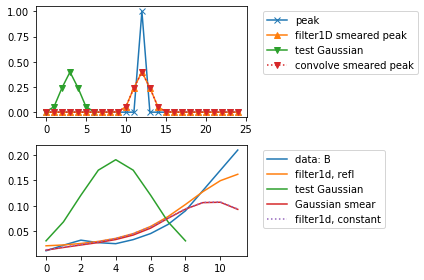

In [35]:
# SCRATCH
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d

In [ ]:
def smooth1d(data, sigma):
    # smooth data with a 1d gaussian kernel
    # sigma = standard deviation of gaussian
    import scipy.ndimage as img
    
    img.scipy.ndimage.gaussian_filter1d

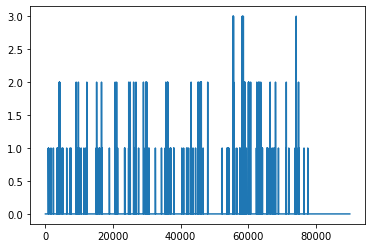

In [46]:
# sigma = standard deviation of gaussian
import scipy.ndimage as img

test = img.gaussian_filter1d(np.transpose(spikesNow), 2)
plt.plot(spikesNow)


In [ ]:
sessNum = 12
unitNum = 4
timePoint = 10

SpikeTrain = matfile["SpikeTrain"][0]
spikesNow = SpikeTrain[sessNum][0][unitNum][0]
pos = matfile["pos"][0]
time = pos[sessNum][:,0][timePoint];


smooth(spikesNow, 1)